<a href="https://colab.research.google.com/github/sujiny123/project/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈로딩

In [58]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
import seaborn as sns

In [4]:
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import polars as pl

# 데이터셋

In [70]:
train_events = pd.read_csv('train_events.csv')
train_series = pd.read_csv('60e51cad2ffb.csv')
train_events = train_events[train_events['series_id']=='60e51cad2ffb']

<ipython-input-70-4a87b8dc69bb>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_series = pd.read_csv('60e51cad2ffb.csv')


In [71]:
df = train_events.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df['hour'] = df['timestamp'].dt.hour
df_morning = df.loc[df['hour']<=12].copy()
df_afternoon = df.loc[df['hour']>12].copy()

In [72]:
print('wake in the morning : ', df_morning.loc[df_morning['event']=='wakeup'].shape[0])
print('go to sleep in the morning : ', df_morning.loc[df_morning['event']=='onset'].shape[0])
print('sleep in the afternoon : ', df_afternoon.loc[df_afternoon['event']=='onset'].shape[0])
print('wake in the afternoon : ', df_afternoon.loc[df_afternoon['event']=='wakeup'].shape[0])

wake in the morning :  3
go to sleep in the morning :  3
sleep in the afternoon :  0
wake in the afternoon :  0


In [73]:
train_events.head()

,series_id,night,event,step,timestamp
5232,60e51cad2ffb,1,onset,7272.0,2017-10-09T22:51:00-0400
5233,60e51cad2ffb,1,wakeup,13140.0,2017-10-10T07:00:00-0400
5234,60e51cad2ffb,2,onset,24636.0,2017-10-10T22:58:00-0400
5235,60e51cad2ffb,2,wakeup,30648.0,2017-10-11T07:19:00-0400
5236,60e51cad2ffb,3,onset,NaN,NaN


In [74]:
train_series.head()

,Unnamed: 0,series_id,step,timestamp,anglez,enmo,night,event
0,47052720,60e51cad2ffb,0,2017-10-09T12:45:00-0400,-14.4789,0.0309,NaN,NaN
1,47052721,60e51cad2ffb,1,2017-10-09T12:45:05-0400,-30.5447,0.0545,NaN,NaN
2,47052722,60e51cad2ffb,2,2017-10-09T12:45:10-0400,-30.2051,0.0572,NaN,NaN
3,47052723,60e51cad2ffb,3,2017-10-09T12:45:15-0400,-62.7261,0.0439,NaN,NaN
4,47052724,60e51cad2ffb,4,2017-10-09T12:45:20-0400,-59.8649,0.0348,NaN,NaN


In [76]:
df = train_series.drop(['Unnamed: 0', 'night','event'], axis=1)

In [77]:
df

,series_id,step,timestamp,anglez,enmo
0,60e51cad2ffb,0,2017-10-09T12:45:00-0400,-14.4789,0.0309
1,60e51cad2ffb,1,2017-10-09T12:45:05-0400,-30.5447,0.0545
2,60e51cad2ffb,2,2017-10-09T12:45:10-0400,-30.2051,0.0572
3,60e51cad2ffb,3,2017-10-09T12:45:15-0400,-62.7261,0.0439
4,60e51cad2ffb,4,2017-10-09T12:45:20-0400,-59.8649,0.0348
...,...,...,...,...,...
113935,60e51cad2ffb,113935,2017-10-16T02:59:35-0400,-9.4275,0.0103
113936,60e51cad2ffb,113936,2017-10-16T02:59:40-0400,-9.4415,0.0102
113937,60e51cad2ffb,113937,2017-10-16T02:59:45-0400,-9.4338,0.0103
113938,60e51cad2ffb,113938,2017-10-16T02:59:50-0400,-9.4812,0.0104


In [78]:
train_events

,series_id,night,event,step,timestamp
5232,60e51cad2ffb,1,onset,7272.0,2017-10-09T22:51:00-0400
5233,60e51cad2ffb,1,wakeup,13140.0,2017-10-10T07:00:00-0400
5234,60e51cad2ffb,2,onset,24636.0,2017-10-10T22:58:00-0400
5235,60e51cad2ffb,2,wakeup,30648.0,2017-10-11T07:19:00-0400
5236,60e51cad2ffb,3,onset,NaN,NaN
5237,60e51cad2ffb,3,wakeup,NaN,NaN
5238,60e51cad2ffb,4,onset,59532.0,2017-10-12T23:26:00-0400
5239,60e51cad2ffb,4,wakeup,64980.0,2017-10-13T07:00:00-0400
5240,60e51cad2ffb,5,onset,NaN,NaN
5241,60e51cad2ffb,5,wakeup,NaN,NaN


In [79]:
train_events['date'] = train_events['timestamp'].str.split('T', expand=True)[0]
train_events['time'] = train_events['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
train_events['timestamp'] = pd.to_datetime(train_events['date']+' '+train_events['time'])
train_events['hour'] = train_events['timestamp'].dt.hour

In [94]:
def plot_series_with_events(series_id, train_series, train_events):
    # Filter the DataFrame based on the series_id
    sample_serie = train_series[train_series['series_id'] == series_id]

    # Convert timestamp to Pandas datetime object
    sample_serie['date'] = sample_serie['timestamp'].str.split('T', expand=True)[0]
    sample_serie['time'] = sample_serie['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
    sample_serie['timestamp'] = pd.to_datetime(sample_serie['date'] + ' ' + sample_serie['time'])

    # Filter event data based on the series_id
    sample_events = train_events[train_events['series_id'] == series_id]
    sample_onset = sample_events.loc[sample_events['event'] == 'onset', 'timestamp'].dropna()
    sample_wakeup = sample_events.loc[sample_events['event'] == 'wakeup', 'timestamp'].dropna()

    def plot_data_and_events(data, ylabel):
        plt.figure(figsize=(20, 3))
        plt.plot(sample_serie['timestamp'], sample_serie[data], label=data, linewidth=1)

        for onset in sample_onset:
            plt.axvline(x=onset, color='r', linestyle='--', label='onset')

        for wakeup in sample_wakeup:
            plt.axvline(x=wakeup, color='g', linestyle='--', label='wakeup')

        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels, new_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in new_labels:
                new_handles.append(handle)
                new_labels.append(label)
                plt.legend(new_handles, new_labels)

        plt.xlabel('Timestamp')
        plt.ylabel(ylabel)
        plt.title(f'{ylabel} over Time with Event Flags - '+series_id)
        plt.show()
    plot_data_and_events('enmo', 'ENMO Value')
    plot_data_and_events('anglez', 'anglez Value')

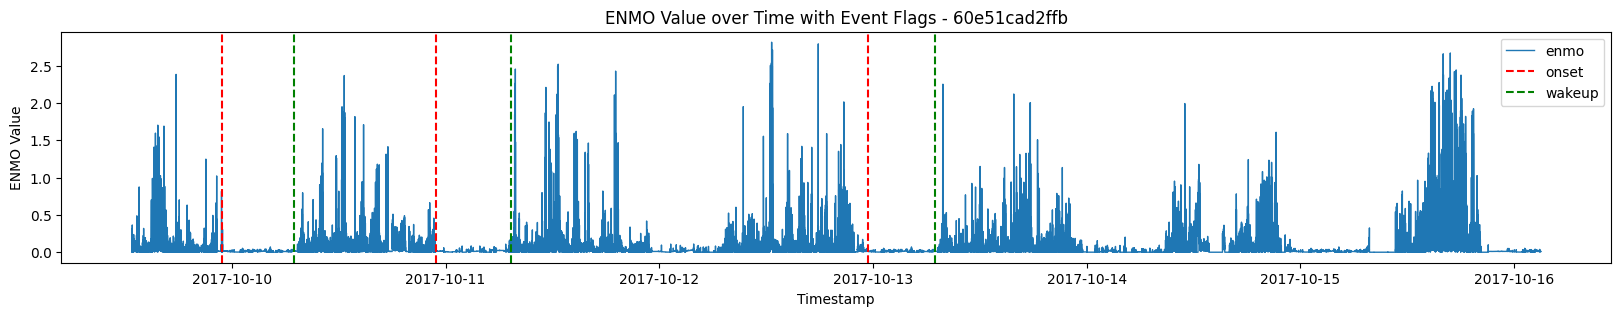

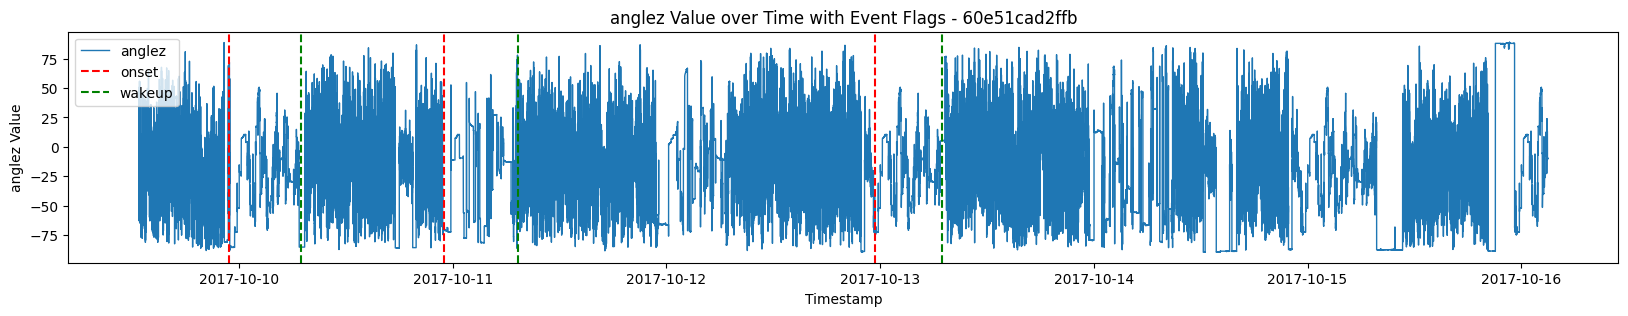

In [95]:
for series_id in train_events['series_id'].unique()[:10]:
    plot_series_with_events(series_id, train_series, train_events)
